# Figure 6: Plot attention weights entropy.

In an independent foraging setting, attentions should.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns

In [3]:
from collab_env.data.file_utils import expand_path, get_project_root

In [7]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from scipy.stats import entropy

import starbars
from scipy.stats import ranksums

## Data

In [8]:
data_names = ['boid_food_basic','boid_food_independent','boid_food_strong'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

### manual input model, result from model selection

In [10]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, ablation),
    ('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
]

In [11]:
rollout_error = None
models_to_consider = [0, 1, 2]

In [13]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = False
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}_ablation'
    else:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
0, Successfully import foodbasic_
n0.005_h3_vr0.5_s2
ablation  0
1, Successfully import foodidpnt_
n0.005_h3_vr0.5_s4
ablation  0
2, Successfully import foodstrong_
n0.005_h3_vr0.5_s0


In [14]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [15]:
datasets.keys()

dict_keys(['boid_food_basic', 'boid_food_independent', 'boid_food_strong'])

## Parse adjacency matrix

In [16]:
models_to_consider = rollout_results.keys()
print(models_to_consider)

dict_keys([0, 1, 2])


In [17]:
print(model_names)
assert len(model_names) == len(rollout_results.keys())

{0: 'foodbasic_\nn0.005_h3_vr0.5_s2', 1: 'foodidpnt_\nn0.005_h3_vr0.5_s4', 2: 'foodstrong_\nn0.005_h3_vr0.5_s0'}


In [18]:
STARTING_FRAME = 5
ENDING_FRAME = 55
MODEL_STARTING_FRAME = 3
NODE_NUM = 21 # 21 boids + 1 food

entropy_dict = {}
ratio_dict = {}
W_output_all = {}

for m in models_to_consider: #rollout_results:
    print(f"Parsing model {m}")
    
    dataname, model_name, n, h, vr, s, _ = all_combinations[ind]
    dataloader = datasets[dataname]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug_batch(
            rollout_results[m], dataloader, vr, STARTING_FRAME, ENDING_FRAME, MODEL_STARTING_FRAME, NODE_NUM
        )

    W_output_all[m] = W_output

Parsing model 0


/Users/dima/git/collab-environment/collab_env/gnn/gnn.py:255: RuntimeWarning: invalid value encountered in divide
  A_output = A / col_sum[np.newaxis, :]


Parsing model 1
Parsing model 2


In [19]:
# creating a dictionary with one specific color per group:

my_pal = {}
for m in rollout_results:

    dataname, model_name, n, h, vr, s,_ = all_combinations[m]
    d = data_names_short[dataname]
    print(d)
    if 'idpnt' in d:
        my_pal[m] = "C1"
    elif 'strong' in d:
        my_pal[m] = "C2"
    else:
        my_pal[m] = "C0"

foodbasic
foodidpnt
foodstrong


In [33]:
#ticklabels = [model_names[c] if isinstance(c, int) else c + '\ndata' for c in entropy_dict]
ticklabels = [a[0] for a in all_combinations]
print(ticklabels)

['boid_food_basic', 'boid_food_independent', 'boid_food_strong']


## Plot attention adjacency matrix entries

In [21]:
def return_food_location(species_configs):
    # find food location
    width = species_configs["A"]['width']
    height = species_configs["A"]['height']
    
    food_config = species_configs["food0"]
    x, y = food_config['x']/width, food_config['y']/height

    return [x, y]

In [22]:
def find_boids_close_to_food(food_loc, predicted_xy, species_configs):
    width = species_configs["A"]['width']
    food_visual_range = species_configs['A']["food_visual_range"]
    food_eating_range = species_configs['A']["food_eating_range"]

    dis = np.sqrt(np.sum((predicted_xy - np.array(food_loc).reshape((1,2))) ** 2, axis = 1))

    condition1 = dis <= food_visual_range/width
    condition2 = dis > food_eating_range/width
    
    return np.logical_and(condition1, condition2)

In [23]:
def figure_data_D(rollout_results, datasets, all_combinations, m_x, W, start_frame = 3, start = 0, end = 50):
    """
    example: m_x, m_y = ['boid_single_species_basic', 'boid_single_species_independent']
    """

    dataname, model_name, n, h, vr, s, _ = all_combinations[m_x]
    dataloader = datasets[dataname]["test_loader"]
    
    _, species = list(dataloader)[0]
    all_bird_ind = species.ravel() == 0 #exclude food/environmental factor
    food_ind = species.ravel() == 1 #food
    #print(food_ind)

    batch_size = rollout_results[0][0]['actual'][0].shape[0]


    if "food" in dataname:
        species_configs = datasets[data_name]["species_configs"]
        food_loc = return_food_location(species_configs)

    entropy_x_all, sum_bird_x_all, sum_food_x_all = [], [], []
    start_ = start - start_frame
    end_ = start_ + end - start
    for file in W[0].keys():
        entropy_x_file = []
        sum_bird_x_file = []
        sum_food_x_file = []
        
        batch = int(np.floor(file/batch_size))
        file_within_batch = file % batch_size
        
        for frame in range(start, end):#range(len(models[m_x]["W_output"][0][file])):
            if "food" in dataname:
                predicted = rollout_results[0][batch]['predicted'][frame + start_frame][file_within_batch].squeeze()
                # restrict to the moments when boids can see food
                # so the adjacency matrix entries can have both nonzero boid and food elements.
                # suggested by Dima
                bird_ind = find_boids_close_to_food(food_loc, predicted, species_configs)
    
            else:
                bird_ind = all_bird_ind
    
            if len(bird_ind) == 0:
                continue
                    
            x = W[0][file][frame][:,bird_ind]
    
            x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
    
            entropy_x = entropy(x_boid, axis = 0)
            entropy_x_file.append(entropy_x)
        
            sum_bird_x = np.mean(x[bird_ind,:])
            sum_food_x = np.mean(x[food_ind,:])
                
            sum_bird_x_file.append(sum_bird_x)
    
            sum_food_x_file.append(sum_food_x)

        entropy_x_all.append(np.mean(np.concatenate(entropy_x_file)))
        sum_bird_x_all.append(np.mean(sum_bird_x_file))
        sum_food_x_all.append(np.mean(sum_food_x_file))
    
    return entropy_x_all, sum_bird_x_all, sum_food_x_all


In [24]:
MODEL_START_TIME = 5 #: W_output_all starts to record at frame 5
start = 0
end = 50

entropy_all = {}
sum_bird = {}
sum_food = {}
for m in models_to_consider:
    entropy_all[m], sum_bird[m], sum_food[m] = figure_data_D(
        rollout_results[m], datasets, all_combinations, m, W_output_all[m], MODEL_START_TIME, start, end)

/var/folders/2j/jdg5vjdx4x3_5tmlzl7nzygh0000gn/T/ipykernel_26830/2176095240.py:48: RuntimeWarning: invalid value encountered in divide
  x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
/Users/dima/git/collab-environment/.venv-310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dima/git/collab-environment/.venv-310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
sum_food_df = pd.DataFrame(sum_food)
sum_bird_df = pd.DataFrame(sum_bird)

### Boid to boid

In [26]:
_, pvalue01 = ranksums(sum_bird_df[0], sum_bird_df[1],'greater',nan_policy = 'omit')
_, pvalue02 = ranksums(sum_bird_df[0], sum_bird_df[2],'less',nan_policy = 'omit')

print(pvalue01, pvalue02)

1.1888904076965733e-76 6.91746843414723e-17


3.0 0.03
3.0 0.03


/var/folders/2j/jdg5vjdx4x3_5tmlzl7nzygh0000gn/T/ipykernel_26830/458848934.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


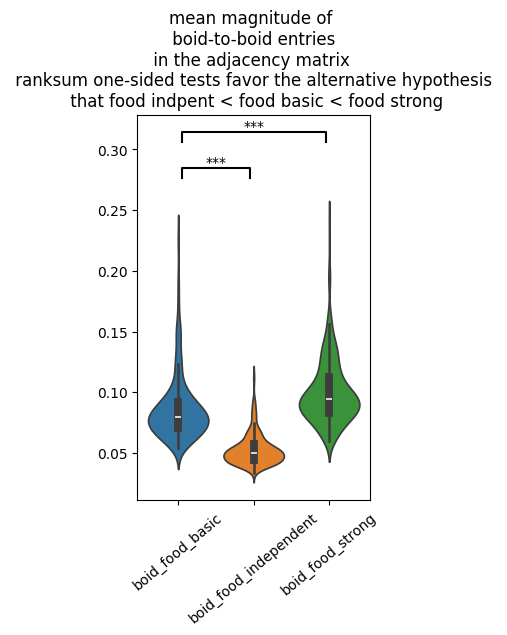

In [34]:
order = [0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(3, 5))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_bird_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-boid entries \n in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")


# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig("food_adj_boid_sum.pdf", bbox_inches="tight")

### Boid to food

In [35]:
_, pvalue01 = ranksums(sum_food_df[0], sum_food_df[1],'greater',nan_policy = 'omit')
_, pvalue02 = ranksums(sum_food_df[0], sum_food_df[2],'less',nan_policy = 'omit')

print(pvalue01, pvalue02)

1.58126396576376e-38 9.464995567166906e-05


3.0 0.03
3.0 0.03


/var/folders/2j/jdg5vjdx4x3_5tmlzl7nzygh0000gn/T/ipykernel_26830/858203058.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


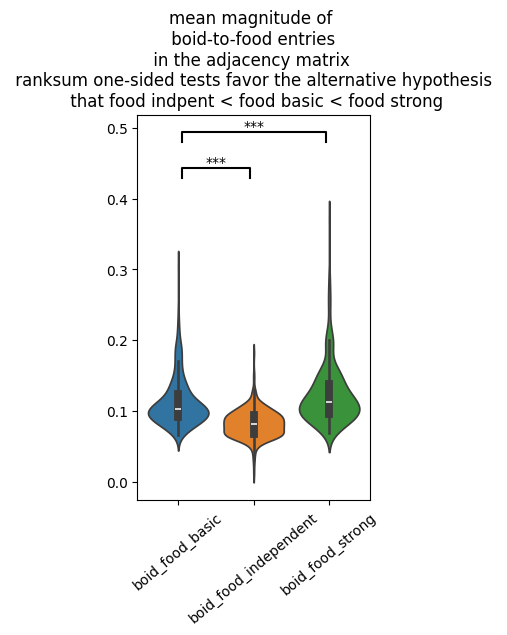

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(3, 5))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_food_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-food entries \n in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")


# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig("food_adj_food_sum.pdf", bbox_inches="tight")
